In [2]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual

import copy

In [3]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]


#variable files on disk
omega_file_full = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/omega_7917.nc'

#lists for plotting
lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

#longitude labels will need to be shifted because we are changing the central longitude in our plotting method
shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

#y axis tick marks and labels: pressure and height
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.0325
vmax = 0.035
contours = np.arange(vmin, vmax, 0.0025)

colormap = cmocean.cm.balance
colorbar_label = r"$hPa \hspace{1} s^{-1} \hspace{1} m^{-2}$"

jja = 'JJA '
#different titles for upward and downward omega
left_title_u = '$-\omega$ Mask, '
left_title_d = '$\omega$ Mask, '
lat_band = str(lat_lims)

#need to change season string here
left_title_up = jja+left_title_u+lat_band
left_title_down = jja+left_title_d+lat_band

#set right title, the total years that our dataset spans
right_title = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

#save figure name for saving output
figure_name_up_jja = 'lon_omegaUp_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_JJA.pdf'
figure_name_d_jja = 'lon_omegaDown_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'massFlux_JJA.pdf'

### Data Import

In this Notebook, I will show how to read in NetCDF files in Python. 

In another program, I will show a method for removing the annual cycle in [Xarray](http://xarray.pydata.org/en/stable/). In that Notebook, I will save a number of variables and their respective monthly anomalies so that they can be loaded directly using NumPy.

In [4]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file_full)

#process variables
omega_ = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
#shortened file: levelist, full file: level
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = p >= 70

#subset for jja months
tidx = np.logical_or(time.month == 6, np.logical_or(time.month == 7, time.month == 8))

#subset new tensors for correct latitude, pressure ranges
omega_lat = omega_[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

In [5]:
#take out monthly means
monthly_means = monthly_means_annual(omega_lat_p, time)

#subtract monthly means, remove annual cycle
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        omega_lat_p[count-1] = omega_lat_p[count-1] - monthly_means[month]
        count = count + 1

In [6]:
#the only months that should show up are 6, 7, 8
print(time.month[tidx])

Int64Index([6, 7, 8, 6, 7, 8, 6, 7, 8, 6,
            ...
            8, 6, 7, 8, 6, 7, 8, 6, 7, 8],
           dtype='int64', length=117)


### Start Mask Here

Here, we are going to make upward and downward pressure velocity masks. It is important to note that upward pressure velocity is negative (because pressure decreases with height). For the upward pressure velocity mask, wherever $\omega$ is negaitive we will change that value to a 1 and wherever it is positive, or downward, we will change that value to a NaN. We can then do the same thing for the downward mask, with the 1's and NaN's flipped.

In [7]:
#copy array for creating mask
mask_up = copy.deepcopy(omega_lat_p)
mask_down = copy.deepcopy(omega_lat_p)

#upward mask: M_up
mask_up[np.where(mask_up > 0)] = np.nan
mask_up[np.where(mask_up < 0)] = 1

#downward mask: M_down
mask_down[np.where(mask_down > 0)] = 1
mask_down[np.where(mask_down < 0)] = np.nan

#MX
mask_var_up = np.multiply(omega_lat_p, mask_up)
mask_var_down = np.multiply(omega_lat_p, mask_down)

/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


In [9]:
#create cos(lat) matrix
cos_lat_ = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), np.array(cos_lat_))

#MXcos(lat) = AX
mask_var_coslat_up = np.multiply(mask_var_up, cos_lat_matrix)
mask_var_coslat_down = np.multiply(mask_var_down, cos_lat_matrix)

#Mcos(lat) = A
mask_up_coslat = np.multiply(mask_up, cos_lat_matrix)
mask_d_coslat = np.multiply(mask_down, cos_lat_matrix)

#nan mean over lat (along lon dimension)
#area_variable masks
mask_var_nanmean_up = np.nanmean(mask_var_coslat_up, axis=2)
mask_var_nanmean_down = np.nanmean(mask_var_coslat_down, axis=2)

#area masks
mask_up_nanmean = np.nanmean(mask_up_coslat, axis=2)
mask_d_nanmean = np.nanmean(mask_d_coslat, axis=2)

/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/jakidxav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


In [10]:
#subset for season here
mask_var_nanmean_up = mask_var_nanmean_up[tidx]
mask_var_nanmean_down = mask_var_nanmean_down[tidx]

mask_up_nanmean = mask_up_nanmean[tidx]
mask_d_nanmean = mask_d_nanmean[tidx]

#integrate, or average over time dimension
#need to nanmean, ΣMXcos(lat) = ΣAX
mean_mask_var_up = np.nanmean(mask_var_nanmean_up, axis=0)
mean_mask_var_down = np.nanmean(mask_var_nanmean_down, axis=0)

#ΣA_total
area_up = np.nanmean(mask_up_nanmean, axis=0)
area_down = np.nanmean(mask_d_nanmean, axis=0)

#(ΣAX_up + ΣAX_down)/ ΣA_total
total_up = np.divide(mean_mask_var_up, area_up)
total_down = np.divide(mean_mask_var_down, area_down)

In [11]:
print(mask_var_nanmean_up.shape)

(117, 28, 240)


In [12]:
#shift array to have Tropics in the middle
#upward jja mask
zeros = np.zeros((28, 240))
zeros[:, 0:120] = mean_mask_var_up[:, 60:180]
zeros[:, 120:180] = mean_mask_var_up[:, 180:240]
zeros[:, 180:240] = mean_mask_var_up[:, 0:60]

#downward jja mask
zeros2 = np.zeros((28, 240))
zeros2[:, 0:120] = mean_mask_var_down[:, 60:180]
zeros2[:, 120:180] = mean_mask_var_down[:, 180:240]
zeros2[:, 180:240] = mean_mask_var_down[:, 0:60]

### $\omega$ Mask Plots

<Figure size 1008x1008 with 0 Axes>

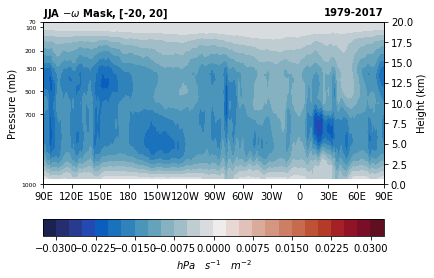

In [13]:
plotting.plot_contours_latHeight(vmin, vmax, zeros, contours, colormap, colorbar_label, left_title_up, right_title, 
                                 p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_up_jja, False)

<Figure size 1008x1008 with 0 Axes>

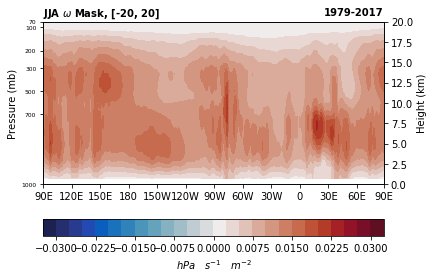

In [14]:
plotting.plot_contours_latHeight(vmin, vmax, zeros2, contours, colormap, colorbar_label, left_title_down, right_title, 
                                 p_list, p_label, lon_list, shifted_labels_eastWest, p_tick_list, z_label, figure_name_d_jja, False)

We can see that in the June, July, August montly subset of the upward pressure velocity mask, there are distinct shallow and deep convection cells in the Eastern and Western Pacific respectively. In the other seasonal subsets, this difference is not as well pronouned which shows that there is some seasonal dependence to the ways in which shallow convection cells form in the Eastern Pacific.